### Transfer Learning

- There are two major transfer learning scenarios as follows:
    - **Finetuning the convnet**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
    - **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is only trained.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device('cuda:0')

- Download 'ants and bees' data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [2]:
samples = datasets.ImageFolder('../hymenoptera_data/train/', transform=transforms.Compose([
                               transforms.Resize((200,200)),
                               transforms.ToTensor(),
                           ]))

In [3]:
img_list=[]
img_iter= iter(samples)

for _ in range(16):
    x, y = next(img_iter)
    img_list.append(x)

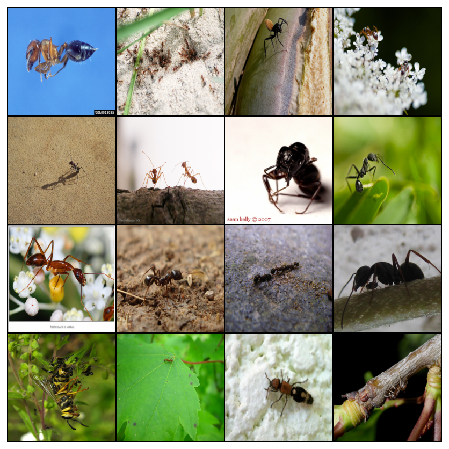

In [4]:
xx = vutils.make_grid(img_list, nrow=4, normalize=True)
xx = np.transpose(xx, (1,2,0))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(xx)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
train_datasets= datasets.ImageFolder('../hymenoptera_data/train/', data_transforms['train'])
valid_datasets= datasets.ImageFolder('../hymenoptera_data/val/', data_transforms['val'])

In [7]:
train_dataloader= DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
valid_dataloader= DataLoader(valid_datasets, batch_size=16, shuffle=False, num_workers=4)

In [8]:
class_names= train_datasets.classes
print(class_names)

['ants', 'bees']


- Very small dataset

In [9]:
print('train:', len(train_datasets), 'valid:',len(valid_datasets))

train: 244 valid: 153


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Fine-tuning: Replace the last fc layer and train all parameters

In [12]:
model_fine_tune = models.resnet18(pretrained=True)

In [13]:
'''
print(model_ft)

  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): 
      (bn1): 
      (relu):
      ...
      
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)
'''

'\nprint(model_ft)\n\n  (layer4): Sequential(\n    (0): BasicBlock(\n      (conv1): \n      (bn1): \n      (relu):\n      ...\n      \n  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))\n  (fc): Linear(in_features=512, out_features=1000, bias=True)\n)\n'

In [14]:
model_fine_tune.fc.in_features

512

In [15]:
model_fine_tune.fc = nn.Linear(in_features=512, out_features=2)  # replace the last fc layer
model= model_fine_tune.to(device)

criterion = nn.CrossEntropyLoss()

# and train all parameters again
optimizer = optim.SGD(model_fine_tune.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
def cal_val_acc(model):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
    
    return running_corrects.double()/len(valid_datasets)

In [17]:
num_epochs = 20
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    
    exp_lr_scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects.double() / len(train_datasets)

    print('epoch: {}, loss: {:.4f} Acc: {:.4f}'.format(
        epoch, epoch_loss, epoch_acc))
    
    val_acc= cal_val_acc(model)
    # deep copy the model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())


print('Best valid accuracy: {:4f}'.format(best_acc))

epoch: 0, loss: 0.6480 Acc: 0.6393
epoch: 1, loss: 0.3263 Acc: 0.8525
epoch: 2, loss: 0.2322 Acc: 0.8893
epoch: 3, loss: 0.2024 Acc: 0.9098
epoch: 4, loss: 0.2275 Acc: 0.8934
epoch: 5, loss: 0.2362 Acc: 0.8811
epoch: 6, loss: 0.1583 Acc: 0.9467
epoch: 7, loss: 0.1578 Acc: 0.9385
epoch: 8, loss: 0.1587 Acc: 0.9385
epoch: 9, loss: 0.1359 Acc: 0.9590
epoch: 10, loss: 0.1378 Acc: 0.9508
epoch: 11, loss: 0.1438 Acc: 0.9385
epoch: 12, loss: 0.1481 Acc: 0.9467
epoch: 13, loss: 0.1018 Acc: 0.9590
epoch: 14, loss: 0.1930 Acc: 0.9262
epoch: 15, loss: 0.1936 Acc: 0.9139
epoch: 16, loss: 0.0943 Acc: 0.9631
epoch: 17, loss: 0.1201 Acc: 0.9590
epoch: 18, loss: 0.1328 Acc: 0.9549
epoch: 19, loss: 0.1080 Acc: 0.9672
Best valid accuracy: 0.947712


#### ConvNet as fixed feature extractor

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [19]:
for param in model_conv.parameters():
    param.requires_grad = False

In [20]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features # num_ftrs=512
model_conv.fc = nn.Linear(num_ftrs, 2)

In [21]:
model = model_conv.to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
# only parameters of final layer are being optimized.
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
num_epochs = 20
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    
    exp_lr_scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects.double() / len(train_datasets)

    print('epoch: {}, loss: {:.4f} Acc: {:.4f}'.format(
        epoch, epoch_loss, epoch_acc))
    
    val_acc= cal_val_acc(model)
    # deep copy the model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())


print('Best valid accuracy: {:4f}'.format(best_acc))

epoch: 0, loss: 0.7286 Acc: 0.5697
epoch: 1, loss: 0.4799 Acc: 0.7254
epoch: 2, loss: 0.3612 Acc: 0.8525
epoch: 3, loss: 0.2660 Acc: 0.8975
epoch: 4, loss: 0.2859 Acc: 0.9016
epoch: 5, loss: 0.2710 Acc: 0.8893
epoch: 6, loss: 0.2010 Acc: 0.9303
epoch: 7, loss: 0.2542 Acc: 0.8975
epoch: 8, loss: 0.2348 Acc: 0.8975
epoch: 9, loss: 0.2665 Acc: 0.8893
epoch: 10, loss: 0.2031 Acc: 0.9098
epoch: 11, loss: 0.2562 Acc: 0.9016
epoch: 12, loss: 0.2054 Acc: 0.9344
epoch: 13, loss: 0.1994 Acc: 0.9221
epoch: 14, loss: 0.2395 Acc: 0.9016
epoch: 15, loss: 0.2519 Acc: 0.9098
epoch: 16, loss: 0.2290 Acc: 0.9098
epoch: 17, loss: 0.1924 Acc: 0.9262
epoch: 18, loss: 0.1971 Acc: 0.9426
epoch: 19, loss: 0.2184 Acc: 0.8934
Best valid accuracy: 0.960784


- **Note**: Fine-tuning approach gives the model more flexibility and the newly trained ResNet might overfit to the small dataset. In this experiment, freezing conv layers as a feature extractor performs better.